## Обработка звука

In [2]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 735.5 MB 15 kB/s 
     |████████████████████████████████| 1.9 MB 46.6 MB/s 
     |████████████████████████████████| 15.3 MB 44.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21

In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset


%matplotlib inline

device="cuda:0"

# Классификация аудиозаписей.

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

- air_conditioner
- car_horn
- children_playing
- dog_bark
- drilling
- engine_idling
- gun_shot
- jackhammer
- siren
-street_music

https://urbansounddataset.weebly.com/urbansound8k.html

### Класс чтения данных

In [14]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!rm -r ./data
!mkdir ./data/
!cd ./data  && unzip /content/drive/MyDrive/audio_dataset.zip && rm /content/drive/MyDrive/audio_dataset.zip 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [16]:

classes = [
    "air_conditioner", 
    "car_horn", 
    "children_playing", 
    "dog_bark",
    "drilling", 
    "engine_idling", 
    "gun_shot", 
    "jackhammer", 
    "siren", 
    "street_music"
]

In [17]:
class AudioDataset(Dataset):
    def __init__(
        self, 
        path_to_csv: str, 
        path_to_folder: str, 
        pad_size: int = 384000,
        sr: int = 44100
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]["Class"]

        wav, sr = torchaudio.load(self.path_to_folder + "/" + str(self.csv.iloc[index]["ID"]) + ".wav")
        lenw = wav.shape[1]

        if sr != self.sr: 
          resampler = torchaudio.transforms.Resample(sr, self.sr)
          wav = resampler(wav)
        
        if wav.shape[1] < self.pad_size:
          wav = torch.cat((wav, torch.zeros((1,self.pad_size-wav.shape[1]))), 1)
          
        wav = wav.squeeze()

        instance = { 
            'x': wav,
            'y': self.class_to_idx[output],
            'len': lenw
        }

        return instance

    def __len__(self):
        return self.csv.shape[0]

In [18]:
train_dataset = AudioDataset("./data/urbansound8k/train_part.csv", "./data/urbansound8k/data")
val_dataset = AudioDataset("./data/urbansound8k/val_part.csv", "./data/urbansound8k/data")

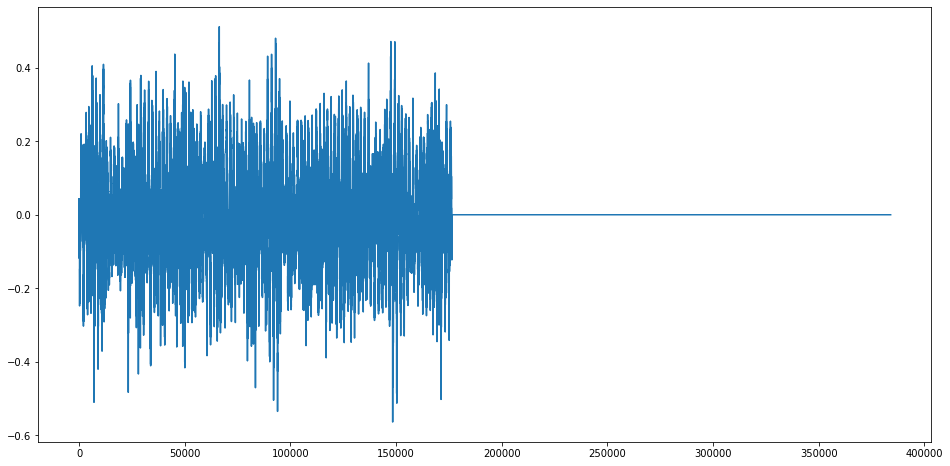

In [19]:
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [20]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    pin_memory=True, 
    drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=32,
    pin_memory=True
)

### Рекуррентная сеть для классификации аудиозаписей по сырому сигналу

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 


In [21]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.first_mlp = nn.Sequential(
            torch.nn.Linear(self.window_length, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(),
            torch.nn.Linear(64, 16)
        )

        self.rnn = nn.LSTM(input_size=16, hidden_size = hidden, num_layers = num_layers, bidirectional=True, batch_first = True)

        self.final_mlp = nn.Sequential(
            torch.nn.Linear(2*hidden*num_layers, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            torch.nn.Linear(256, 10)
        )

    def forward(self, x, lens) -> torch.Tensor:

        batch_windows = x.unfold(1, self.window_length, self.hop_length).reshape(x.shape[0]*1497, 1024)

    
        batch_windows_feautures = self.first_mlp(batch_windows).reshape(x.shape[0],1497,16) # прменяю первую полносвязную сеть

        output, (h_n,c_n) = self.rnn(batch_windows_feautures) 

        hidden_flattened = torch.cat((h_n[0,:,:], h_n[1,:,:], h_n[2,:,:], h_n[3,:,:]), axis = 1) 
          
        return self.final_mlp(hidden_flattened) # применяю к скрытым состояниям последнюю сеть

Обучаю получившуюся модель.

In [22]:
def train_audio_clfr(
    model, 
    optimizer, 
    train_dataloader, 
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None, 
    augmentation=None,
    num_epochs=10, device='cuda:0',
    verbose_num_iters=10
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):  
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [23]:
rnn_raw = RecurrentRawAudioClassifier()

device='cuda:0'
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


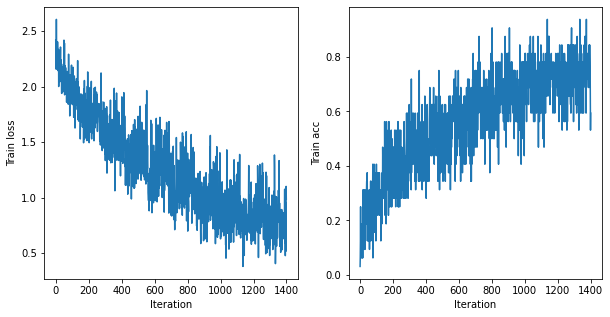

In [24]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаю метрики на валидационном датасете.

In [25]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs], 
            [p[0] for p in pred_true_pairs], 
            normalize="true"
        ),
        columns=classes, 
        index=classes
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.3508021390374332


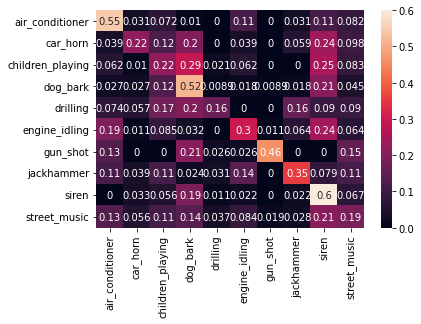

In [26]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

Дело в том, что у нас нет аугментации. которая могла бы помочь с переобучением. Так мы видим, что модель лучше работает на высокочастотных звуках, чем на низкочистотных. Также можно выделить то, что звуки имеют довольно много шумов, что также мешает обучению. По итогу модель лучше предсказывает тренировочную выборку. 

### Построение Мел-cпектрограмм

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

In [27]:
from torchaudio.transforms import MelSpectrogram

def compute_log_melspectrogram_reference(
    wav_batch, 
    lens,
    sr,
    device="cpu"
):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
        ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


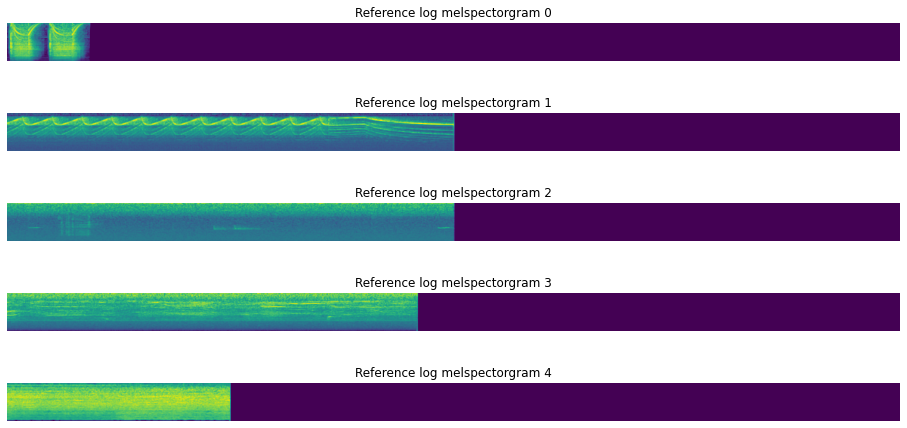

In [28]:
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

In [29]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [30]:
windows = wav_batch.unfold(1, win_length, hop_length) 
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

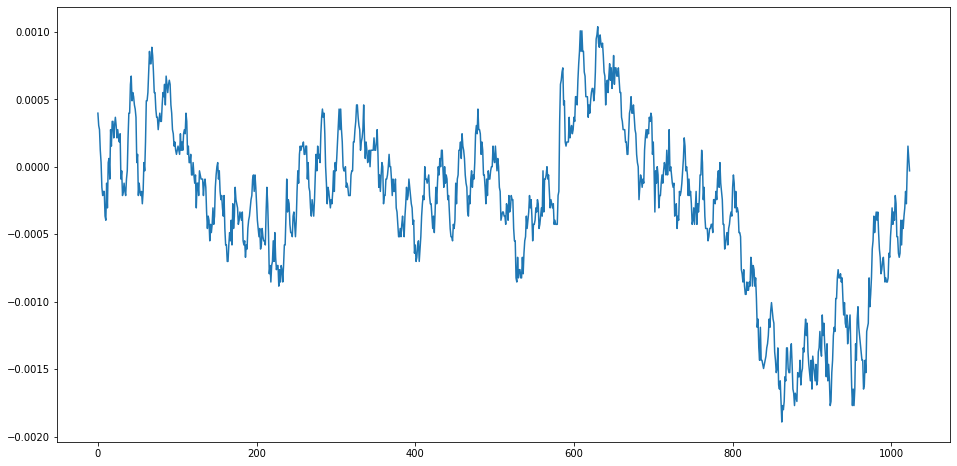

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Применю косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создам косинусоидальный фильтр и умножу его поэлементно на все окна.

In [32]:
filter = torch.hann_window(len(windows[0, 0])) # создаю фильтр
windows_with_applied_filter = windows * filter[None, None, :]

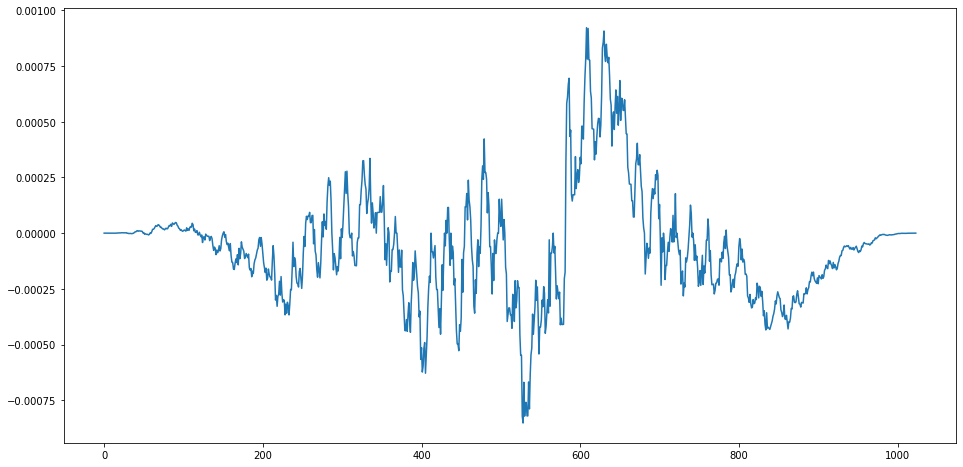

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` применю дискретное преобразование фурье к каждому окну и возьму первые `n_fft // 2 + 1` компоненты./

In [34]:
fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft) # преобразоване фурье
fft_magnitudes = torch.abs(fft_features ** 2)[:,:,:n_fft//2+1] # магнитуды
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создаю класс для перевода магнитуд в Мел-шкалу.

In [35]:
melscale =  torchaudio.transforms.MelScale(n_mels=n_mels, n_stft = n_fft//2+1, sample_rate = sr) 

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

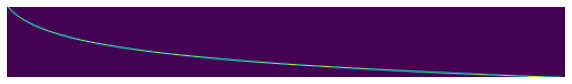

In [36]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

In [37]:
fft_magnitudes.transpose(2,1).shape
fft_magnitudes[0]

tensor([[3.7074e-03, 3.6302e-04, 5.4775e-03,  ..., 3.8552e-07, 1.4408e-07,
         5.9675e-08],
        [2.4890e-02, 3.2240e-02, 5.2514e-02,  ..., 3.8363e-07, 2.0435e-07,
         1.4756e-07],
        [1.6611e-02, 2.1255e-02, 9.0062e-02,  ..., 3.4621e-08, 3.8958e-07,
         9.1114e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [38]:
mel_spectrogram = melscale(fft_magnitudes.transpose(2,1)) # перевед магнитуд в мел-шкалу
assert mel_spectrogram.shape == (32, 64, 1497)

Сделаю обрезку значений по `1e-5` и применю `torch.log` для получения логарифмированной Мел-спектрограммы.

In [39]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

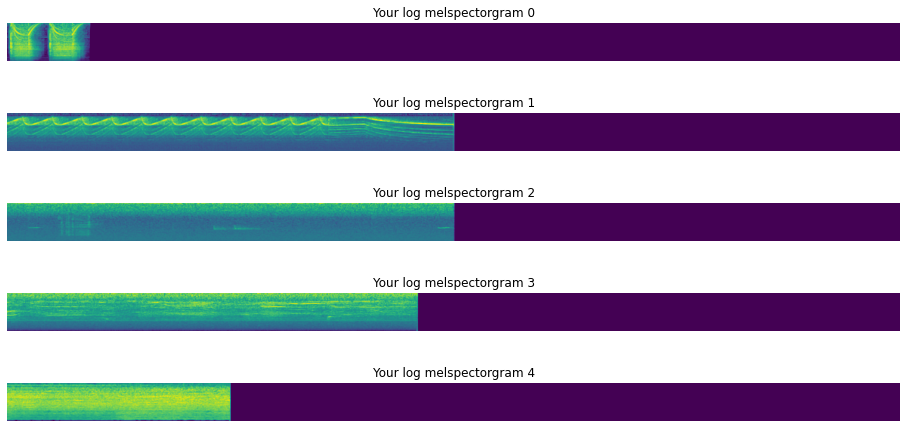

In [40]:
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

In [41]:
def compute_log_melspectrogram(
    wav_batch,
    lens,
    sr,
    device="cuda:0"
):
  windows = wav_batch.unfold(1, 1024, 256).to(device)

  filter = torch.hann_window(len(windows[0, 0])).to(device)
  
  windows_with_applied_filter = windows * filter[None, None, :]
  windows_with_applied_filter = windows_with_applied_filter.to(device)
  
  fft_features = torch.fft.fft(windows_with_applied_filter, n=1024)
  fft_features = fft_features.to(device)

  fft_magnitudes = torch.abs(fft_features ** 2)[:,:,:1024//2+1]

  fft_magnitudes = fft_magnitudes.to(device)
  
  melscale =  torchaudio.transforms.MelScale(n_mels=64, n_stft = 1024//2+1, sample_rate = sr).to(device)
  mel_spectrogram = melscale(fft_magnitudes.transpose(2,1)).to(device)
  
  logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)).to(device)

  return logmel_spectrogram, lens//256

### Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам 

In [42]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.rnn =  nn.LSTM(input_size=64, hidden_size = hidden, num_layers = num_layers, bidirectional=True, batch_first = True) 


        self.final_mlp = nn.Sequential( 
            torch.nn.Linear(2*hidden*num_layers, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            torch.nn.Linear(256, 10)
        )


    def forward(self, x, lens):
        batch_windows_feautures = x

        output, (h_n,c_n) = self.rnn(batch_windows_feautures.transpose(2,1))

        hidden_flattened = torch.cat((h_n[0,:,:], h_n[1,:,:], h_n[2,:,:], h_n[3,:,:]), axis = 1)
          
        return self.final_mlp(hidden_flattened)

In [43]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 9


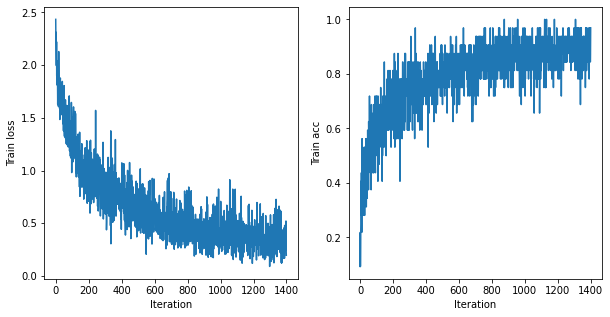

In [44]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Val accuracy: 0.8342245989304813


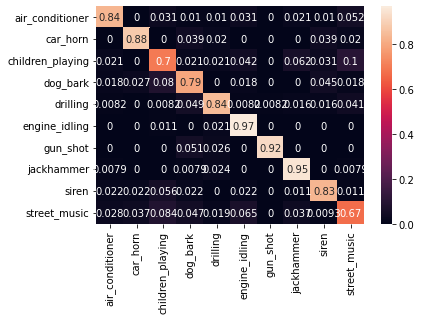

In [45]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

### Cверточная сеть для классификации аудиозаписей по мелспектрограммам. 

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны.Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10


In [46]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(16,32, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(32,64, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(64,128, kernel_size=(3,3), padding = 1),
            torch.nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(2,2)),
            torch.nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.final_mlp = nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.BatchNorm1d(128),
            nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [47]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 9


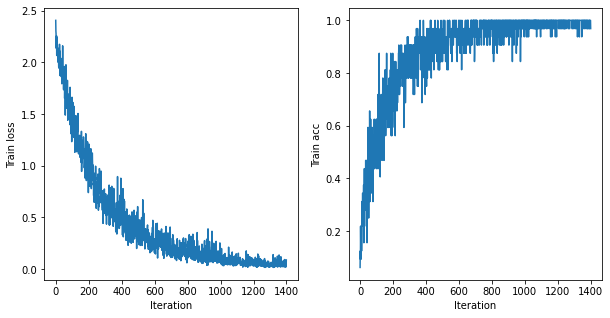

In [48]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Val accuracy: 0.9433155080213904


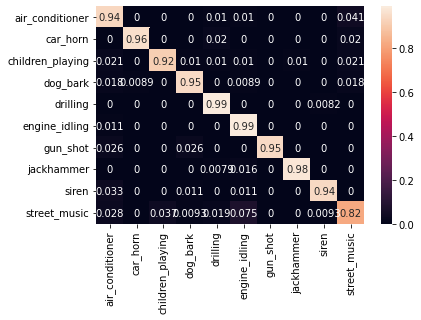

In [49]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

### Аугментация SpecAugment

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.


In [50]:
import random

class SpectAugment:
    def __init__(
        self,
        filling_value = "mean",
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        
        spect1 = torch.clone(spect)

        for n in range(spect1.shape[0]):
          
          filval = spect1[n:,:,:lens[n]].mean()*int(self.filling_value == "mean") # считаю средние 
          

          for i in range(self.n_time_masks): # провожу замену по шкале time 
            time_0 = random.randint(0, spect1[n:,:,:lens[n]].shape[1])
            time_1 = random.randint(time_0, time_0 + self.max_time)
            spect[n:,:,time_0:time_1] = filval


          for i in range(self.n_freq_masks): # провожу замену по шкале freq
            freq_0 = random.randint(0, spect1.shape[0])
            freq_1 = random.randint(freq_0, freq_0 + self.max_freq)
            spect[n:,freq_0:freq_1,:] = filval
          

        return spect, lens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


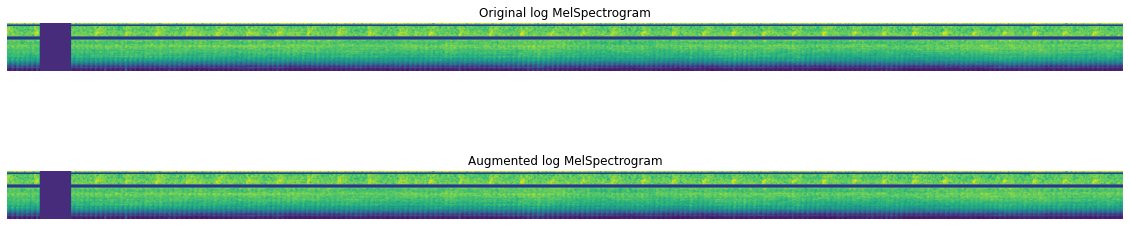

In [51]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [52]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 3


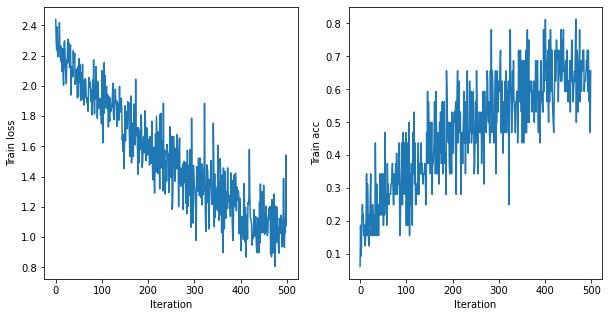

In [ ]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20)

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)